# Baixando vias do OpenStreetMap com **OSMnx** — passo a passo
## Ana Luisa Maffini
### analuisamaffini@gmail.com
### 2025

**Objetivos**:
1) Instalar e configurar o OSMnx
2) Selecionar a área de estudo (nome do lugar **ou** bounding box)
3) Baixar a rede viária do OpenStreetMap
4) Converter o grafo em GeoDataFrames (nós/arestas)
5) Projetar para UTM, visualizar e salvar (GeoPackage/Shapefile)
6) Dicas de erros comuns

## 1) Instalação

Rode **apenas** se ainda não tiver as bibliotecas. No Google Colab, rode esta célula.

In [7]:
# Se estiver no Google Colab ou em um ambiente novo, descomente e rode:
!pip install "numpy<2" shapely
!pip -q install osmnx geopandas matplotlib pyogrio shapely==2.0.4

# Observações:
# - 'pyogrio' acelera leitura/escrita geoespacial.
# - shapely 2.0+ é recomendado pelo OSMnx.


Defaulting to user installation because normal site-packages is not writeable


## 2) Importações e configurações

In [1]:
import sys, os, subprocess, json
import numpy as np
import shapely
import geopandas as gpd
import matplotlib as plt

print("PYTHON EXECUTÁVEL DO KERNEL:", sys.executable)
print("Versões no KERNEL atual:")
print("  numpy   :", np.__version__)
print("  shapely :", shapely.__version__)
print("  geopandas:", gpd.__version__)

# Caminhos do pip/python que o kernel enxerga
print("\nonde está o pip chamado via python -m pip?")
print(subprocess.check_output([sys.executable, "-m", "pip", "--version"]).decode())

# Teste mínimo do Shapely (se falhar aqui, é 100% mismatch binário)
from shapely.geometry import box
try:
    u = shapely.union_all([box(0,0,1,1), box(1,1,2,2)])
    print("Teste shapely.union_all OK ->", u.geom_type)
except Exception as e:
    print("Teste union_all FALHOU:", repr(e))

PYTHON EXECUTÁVEL DO KERNEL: C:\Users\analu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe
Versões no KERNEL atual:
  numpy   : 1.26.4
  shapely : 2.0.4
  geopandas: 1.1.1

onde está o pip chamado via python -m pip?
pip 25.3 from C:\Users\analu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pip (python 3.12)

Teste shapely.union_all OK -> MultiPolygon


In [2]:
import osmnx as ox
import geopandas as gpd

# Configurações úteis para o OSMnx
ox.settings.use_cache = True      # guarda no cache para acelerar execuções futuras
ox.settings.log_console = True    # mostra logs no console (ótimo para depurar)

# (Opcional) Se sua conexão estiver lenta ou a área for grande:
# ox.settings.overpass_settings = {'timeout': 180}  # segundos


## 3) Como escolher a área?

**Opção A — Nome do lugar** (mais simples):
- Ex.: "Porto Alegre, Rio Grande do Sul, Brazil" ou "Santa Maria, RS, Brazil"

**Opção B — Bounding Box** (coordenadas em graus decimais):
- Informe `north` (lat norte), `south` (lat sul), `east` (lon leste), `west` (lon oeste)
- Atenção: `north > south` e `east > west`

### 3A) Download por **nome do lugar**

In [3]:
# === Ajuste aqui o nome do lugar ===
place_name = "Humaitá, Rio Grande do Sul, Brazil"

# Tipo de rede: 'drive' (carros), 'walk' (a pé), 'bike', 'all', 'all_private'
network_type = "drive"


# Baixar o grafo de vias (ruas) do OSM para a área escolhida
G_place = ox.graph_from_place(place_name, network_type=network_type, simplify=True)

#Converter o grafo em GeoDataFrames: nós (nodes) e arestas (edges)
nodes_place, edges_place = ox.graph_to_gdfs(G_place)

print(nodes_place.shape, "nós")
print(edges_place.shape, "arestas")
edges_place.head()


(426, 4) nós
(1104, 12) arestas


osmid       highway lanes maxspeed  oneway  \
u          v          key                                                   
2506348089 4763224813 0    243215754      tertiary     2       60   False   
           4763224818 0    458881013  unclassified   NaN      NaN   False   
2506348207 2506485206 0    299305775     secondary   NaN      NaN    True   
           2506485310 0    431686379     secondary   NaN      NaN   False   
2506485206 2506485207 0    299305775     secondary   NaN      NaN    True   

                          reversed       length  \
u          v          key                         
2506348089 4763224813 0       True  1071.648381   
           4763224818 0      False  1952.411315   
2506348207 2506485206 0      False    12.019500   
           2506485310 0       True   435.316964   
2506485206 2506485207 0      False    19.049936   

                                                                    geometry  \
u          v          key                                                      
2506348089 4763224813 0    LINESTRING (-53.95634 -27.60233, -53.9567 -27....   
           4763224818 0    LINESTRING (-53.95634 -27.60233, -53.95608 -27...   
2506348207 2506485206 0    LINESTRING (-53.97001 -27.57122, -53.97013 -27...   
           2506485310 0    LINESTRING (-53.97001 -27.57122, -53.96837 -27...   
2506485206 2506485207 0    LINESTRING (-53.97013 -27.57124, -53.9703 -27....   

                               ref name junction bridge  
u          v          key                                
2506348089 4763224813 0        NaN  NaN      NaN    NaN  
           4763224818 0        NaN  NaN      NaN    NaN  
2506348207 2506485206 0    ERS-207  NaN      NaN    NaN  
           2506485310 0    ERS-207  NaN      NaN    NaN  
2506485206 2506485207 0    ERS-207  NaN      NaN    NaN

### 3B) Download por **Bounding Box**

In [ ]:
# === Ajuste aqui sua bounding box ===
north, south = -29.95, -30.15   # latitudes (north > south)
east,  west  = -51.05, -51.30   # longitudes (east > west)

network_type_bbox = "drive"

G_bbox = ox.graph_from_bbox(north=north, south=south, east=east, west=west,
                            network_type=network_type_bbox, simplify=True)

nodes_bbox, edges_bbox = ox.graph_to_gdfs(G_bbox)
print(nodes_bbox.shape, "nós")
print(edges_bbox.shape, "arestas")
edges_bbox.head()


## 4) Projeção para UTM e visualização

CRS original: epsg:4326
CRS projetado (UTM): EPSG:32722


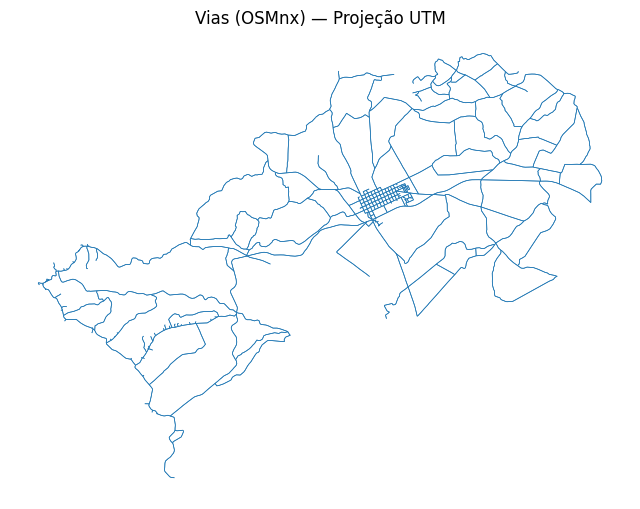

In [4]:
# Vamos seguir com o resultado por nome do lugar ('edges_place').
# Se preferir bbox, troque 'edges_place' por 'edges_bbox' nas linhas abaixo.
edges = edges_place.copy()

# Projetar para um CRS métrico apropriado (UTM) automaticamente
edges_utm = edges.to_crs(edges.estimate_utm_crs())

print("CRS original:", edges.crs)
print("CRS projetado (UTM):", edges_utm.crs)

# Plot rápido
ax = edges_utm.plot(figsize=(8, 8), linewidth=0.5)
ax.set_title("Vias (OSMnx) — Projeção UTM")
ax.set_axis_off()


## 5) Salvar em GeoPackage e Shapefile

In [5]:
saida_gpkg = "vias_osmnx.gpkg"
saida_shp  = "vias_osmnx_shp"   # será uma pasta com arquivos .shp/.dbf/.shx etc.

# Salvar GeoPackage (camada 'edges')
edges_utm.to_file(saida_gpkg, layer="edges", driver="GPKG")

# Salvar Shapefile
edges_utm.to_file(saida_shp, driver="ESRI Shapefile")

print(f"Arquivos salvos: {saida_gpkg}  e  pasta {saida_shp}/")


Arquivos salvos: vias_osmnx.gpkg  e  pasta vias_osmnx_shp/


## 6) Filtrar vias por atributo (`highway`)

In [ ]:
principais = {"motorway", "trunk", "primary", "secondary"}

mask_principais = edges_utm["highway"].astype(str).apply(
    lambda v: any(h in v for h in principais)
)
vias_principais = edges_utm[mask_principais].copy()

print(f"Total de vias: {len(edges_utm)} | Vias principais: {len(vias_principais)}")

ax = vias_principais.plot(figsize=(8,8), linewidth=0.8)
ax.set_title("Vias principais (motorway/trunk/primary/secondary)")
ax.set_axis_off()


## 7) Métrica simples: comprimento total

In [ ]:
comprimento_km = edges_utm["length"].sum() / 1000.0
print(f"Comprimento total de vias na área: {comprimento_km:.2f} km")


## 8) Dicas e erros comuns

- **HTTP 429 (Too Many Requests)**: a API do Overpass limitou suas requisições.
  - Espere alguns minutos e tente novamente.
  - Mantenha `ox.settings.use_cache = True` (já ativo).
  - Evite áreas muito grandes; recorte por bairros/municípios.
- **Timeout** (conexão lenta/área muito grande):
  - Aumente `timeout`: `ox.settings.overpass_settings = {'timeout': 180}`.
  - Prefira redes menores: `network_type="drive"` < `"all"`.
- **Projeção/CRS**: para medir distâncias/áreas, use CRS métrico (ex.: UTM).
- **Shapefile**: pode truncar nomes de campos/encoding; prefira **GeoPackage**.
- **Resultados vazios**: confira a grafia de `place_name`; em bbox, garanta `north>south` e `east>west`.